In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs
import pint_xarray
import cf_xarray as cfxr
from eofs.xarray import Eof


In [2]:
import seaborn as sns

In [3]:
from dask.distributed import Client, LocalCluster
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35329 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35329/status,
Dashboard: /proxy/35329/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36971,Workers: 7
Dashboard: /proxy/35329/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:33075,Total threads: 2
Dashboard: /proxy/45787/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:34845,


In [4]:
def roll_lon2(df):
    df.coords['GRID_X_T'] = (df.coords['GRID_X_T'] + 360) % 360# - 180
    df = df.sortby(df.GRID_X_T)
    return df

In [5]:
mask = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/sst_restore_mask_25N_25S_5deg_damping_trop_pacific.nc", decode_times=False)

In [6]:
mask = mask.restore_mask

In [7]:
mask0 = (mask*0)

In [8]:
import scipy

In [9]:
def create_ellipse(mask, centre_lon, width, height):
    mask0 = (mask*0)
    # Create a 2D grid of latitudes and longitudes
    lons, lats = np.meshgrid(mask.GRID_X_T, mask.GRID_Y_T)

    # Create an ellipse-shaped mask
    center_lon = centre_lon  # Center longitude of the ellipse
    center_lat = 0   # Center latitude of the ellipse
    semi_major_axis = width/2  # Semi-major axis of the ellipse in degrees
    semi_minor_axis = height/2  # Semi-minor axis of the ellipse in degrees

    # Equation of the ellipse: (x - x0)**2 / a**2 + (y - y0)**2 / b**2 = 1
    ellipse_mask = ((lons - center_lon) ** 2) / (semi_major_axis ** 2) + ((lats - center_lat) ** 2) / (semi_minor_axis ** 2) <= 1
    #now add in linear damping over 5 gridcells
    t = ellipse_mask.astype(int)
    t1 = scipy.ndimage.binary_erosion(t)
    t2 = scipy.ndimage.binary_erosion(t1)
    t3 = scipy.ndimage.binary_erosion(t2)
    t4 = scipy.ndimage.binary_erosion(t3)
    t5 = scipy.ndimage.binary_erosion(t4)
    t01 = t-t1
    t03 = t-t2-t01
    t05 = t-t3-t03-t01
    t07 = t-t4-t05-t03-t01
    t09 = t-t5-t07-t05-t03-t01
    t_1L = t-t09-t07-t05-t03-t01
    t_taperL = t_1L +(0.9*t09) +(0.7*t07)+(0.5*t05)+(0.3*t03)+(0.1*t01)
    
    # Create a DataArray with the mask
    mask_dataarray = xr.DataArray(t_taperL, dims=('GRID_Y_T', 'GRID_X_T'), coords={'GRID_Y_T': mask.GRID_Y_T, 'GRID_X_T': mask.GRID_X_T})

    # Apply the mask to your DataArray
    dataarray_masked = mask0 + mask_dataarray
    return dataarray_masked

In [10]:
CP_mask = create_ellipse(mask, -160, 60, 20)

In [11]:
EP_mask = create_ellipse(mask, -110, 60, 20)

In [12]:
#load in climatology and the anomly data. Mask the anmly and then add to climatology. 

In [13]:
model_clim = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/global_sst_restoring_cm000_climatology_0951-1150.nc", decode_cf=False)

In [14]:
MC = model_clim.temp

In [15]:
time = np.linspace(1, 15, 15)

# Define the y values using the scaled cosine function
cosine_curve = 1.5*(1-(np.cos((time/16)*2*np.pi)))
#cosine_curve = -1.5 * (1 - np.cos(time - phase_shift)) +3
#cosine_curve -= cosine_curve[0]
#cosine_curve[:2] = 0
#da_cosine_curve = xr.DataArray(cosine_curve, coords={'month': np.arange(5,20,1)}, dims=['month'])

In [16]:
cosine_curve

array([0.1141807 , 0.43933983, 0.92597485, 1.5       , 2.07402515,
       2.56066017, 2.8858193 , 3.        , 2.8858193 , 2.56066017,
       2.07402515, 1.5       , 0.92597485, 0.43933983, 0.1141807 ])

In [17]:
cosine_curve

array([0.1141807 , 0.43933983, 0.92597485, 1.5       , 2.07402515,
       2.56066017, 2.8858193 , 3.        , 2.8858193 , 2.56066017,
       2.07402515, 1.5       , 0.92597485, 0.43933983, 0.1141807 ])

In [18]:
new_curve = np.concatenate((np.zeros(4), cosine_curve, np.zeros(5)))

In [19]:
(new_curve)

array([0.        , 0.        , 0.        , 0.        , 0.1141807 ,
       0.43933983, 0.92597485, 1.5       , 2.07402515, 2.56066017,
       2.8858193 , 3.        , 2.8858193 , 2.56066017, 2.07402515,
       1.5       , 0.92597485, 0.43933983, 0.1141807 , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [58]:
#split array into 2
cosin_yr1 = new_curve[:12]
cosin_yr2 = new_curve[12:]

In [59]:
cosin_yr1_Jan = cosin_yr1.copy()
cosin_yr1_Jul = cosin_yr1.copy()


In [60]:
cosin_yr1_Jan[-1] = 0

In [61]:
cosin_yr1_Jul[0] = cosin_yr2.copy()[0]

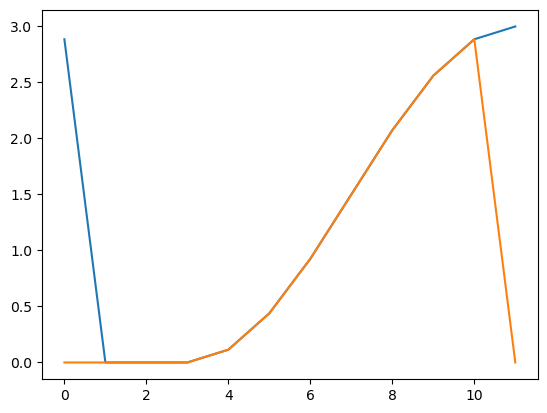

In [62]:
plt.plot(cosin_yr1_Jul)
plt.plot(cosin_yr1_Jan)


In [63]:
cosin_yr2_Jan = cosin_yr2.copy()
cosin_yr2_Jul = cosin_yr2.copy()

In [64]:
cosin_yr2_Jan[-1] = cosin_yr1.copy()[-1]
cosin_yr2_Jul[0] = 0

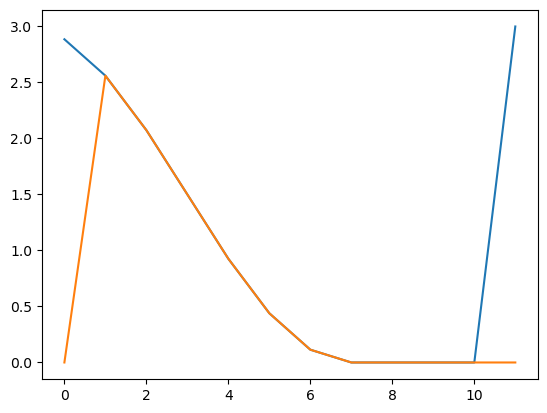

In [65]:
plt.plot(cosin_yr2_Jan)
plt.plot(cosin_yr2_Jul)


In [66]:
da_cosine_curve1_jan = xr.DataArray(cosin_yr1_Jan, coords={'TIME': mask.TIME}, dims=['TIME'])
da_cosine_curve2_jan = xr.DataArray(cosin_yr2_Jan, coords={'TIME': mask.TIME}, dims=['TIME'])

da_cosine_curve1_jul = xr.DataArray(cosin_yr1_Jul, coords={'TIME': mask.TIME}, dims=['TIME'])
da_cosine_curve2_jul = xr.DataArray(cosin_yr2_Jul, coords={'TIME': mask.TIME}, dims=['TIME'])

In [71]:
EP_clim1_jan = (EP_mask*da_cosine_curve1_jan)
EP_clim2_jan = (EP_mask*da_cosine_curve2_jan)

EP_clim1_jul = (EP_mask*da_cosine_curve1_jul)
EP_clim2_jul = (EP_mask*da_cosine_curve2_jul)

CP_clim1_jan = (CP_mask*da_cosine_curve1_jan)
CP_clim2_jan = (CP_mask*da_cosine_curve2_jan)

CP_clim1_jul = (CP_mask*da_cosine_curve1_jul)
CP_clim2_jul = (CP_mask*da_cosine_curve2_jul)


In [98]:
idealised_EP_anom_yr1_jan = MC + EP_clim1_jan
idealised_EP_anom_yr2_jan = MC + EP_clim2_jan

idealised_EP_anom_yr1_jul = MC + EP_clim1_jul
idealised_EP_anom_yr2_jul = MC + EP_clim2_jul

In [99]:
idealised_CP_anom_yr1_jan = MC + CP_clim1_jan
idealised_CP_anom_yr2_jan = MC + CP_clim2_jan

idealised_CP_anom_yr1_jul = MC + CP_clim1_jul
idealised_CP_anom_yr2_jul = MC + CP_clim2_jul

In [83]:
idealised_EP_anom_yr1_jan = idealised_EP_anom_yr1_jan.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
idealised_EP_anom_yr1_jan = idealised_EP_anom_yr1_jan.to_dataset(name = 'temp')
idealised_EP_anom_yr1_jan = idealised_EP_anom_yr1_jan.assign_attrs({"description": "Idealised SST for year 0 evolution of EP El Nino events generated with monthly SST climatology from years 951-1150 of ACCESS-CM2 piControl (suite cm000) plus cosine curve that goes from 0 to 3 between May(0) and July (1) (no anomaly added to other times). No anom in Decemeber for interpolation purposes. For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 09/05/24"})

idealised_EP_anom_yr1_jan = idealised_EP_anom_yr1_jan[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
# Save the data array to the output file
idealised_EP_anom_yr1_jan.to_netcdf("/g/data/e14/sm2435/Pacemaker/Idealised_EP_anomaly_yr0_01.nc", encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

In [84]:
idealised_EP_anom_yr1_jul = idealised_EP_anom_yr1_jul.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
idealised_EP_anom_yr1_jul = idealised_EP_anom_yr1_jul.to_dataset(name = 'temp')
idealised_EP_anom_yr1_jul = idealised_EP_anom_yr1_jul.assign_attrs({"description": "Idealised SST for year 0 evolution of EP El Nino events generated with monthly SST climatology from years 951-1150 of ACCESS-CM2 piControl (suite cm000) plus cosine curve that goes from 0 to 3 between May(0) and July (1) (no anomaly added to other times). January anomly is the anomaly in jan of following year for interpolation purposes.  For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 09/05/24"})

idealised_EP_anom_yr1_jul = idealised_EP_anom_yr1_jul[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
# Save the data array to the output file
idealised_EP_anom_yr1_jul.to_netcdf("/g/data/e14/sm2435/Pacemaker/Idealised_EP_anomaly_yr0_07.nc", encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

In [100]:
idealised_EP_anom_yr2_jan = idealised_EP_anom_yr2_jan.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
idealised_EP_anom_yr2_jan = idealised_EP_anom_yr2_jan.to_dataset(name = 'temp')
idealised_EP_anom_yr2_jan =idealised_EP_anom_yr2_jan.assign_attrs({"description": "Idealised SST for year 1 evolution of EP El Nino events generated with monthly SST climatology from years 951-1150 of ACCESS-CM2 piControl (suite cm000) plus cosine curve that goes from 0 to 3 between May(0) and July (1) (no anomaly added to other times). December anomaly is the anomaly in Dec of previous year for interpolation purposes. For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 09/05/24"})

idealised_EP_anom_yr2_jan = idealised_EP_anom_yr2_jan[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
# Save the data array to the output file
idealised_EP_anom_yr2_jan.to_netcdf("/g/data/e14/sm2435/Pacemaker/Idealised_EP_anomaly_yr1_01.nc", encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

In [101]:
idealised_EP_anom_yr2_jul = idealised_EP_anom_yr2_jul.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
idealised_EP_anom_yr2_jul = idealised_EP_anom_yr2_jul.to_dataset(name = 'temp')
idealised_EP_anom_yr2_jul =idealised_EP_anom_yr2_jul.assign_attrs({"description": "Idealised SST for year 1 evolution of EP El Nino events generated with monthly SST climatology from years 951-1150 of ACCESS-CM2 piControl (suite cm000) plus cosine curve that goes from 0 to 3 between May(0) and July (1) (no anomaly added to other times). January anomaly is 0 (so the value isn't interpolated up) for interpolation purposes. For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 09/05/24"})

idealised_EP_anom_yr2_jul = idealised_EP_anom_yr2_jul[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
# Save the data array to the output file
idealised_EP_anom_yr2_jul.to_netcdf("/g/data/e14/sm2435/Pacemaker/Idealised_EP_anomaly_yr1_07.nc", encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

In [87]:
#save CP

In [88]:
idealised_CP_anom_yr1_jan = idealised_CP_anom_yr1_jan.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
idealised_CP_anom_yr1_jan = idealised_CP_anom_yr1_jan.to_dataset(name = 'temp')
idealised_CP_anom_yr1_jan = idealised_CP_anom_yr1_jan.assign_attrs({"description": "Idealised SST for year 0 evolution of CP El Nino events generated with monthly SST climatology from years 951-1150 of ACCESS-CM2 piControl (suite cm000) plus cosine curve that goes from 0 to 3 between May(0) and July (1) (no anomaly added to other times). No anom in Decemeber for interpolation purposes. For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 09/05/24"})

idealised_CP_anom_yr1_jan = idealised_CP_anom_yr1_jan[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
# Save the data array to the output file
idealised_CP_anom_yr1_jan.to_netcdf("/g/data/e14/sm2435/Pacemaker/Idealised_CP_anomaly_yr0_01.nc", encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

In [89]:
idealised_CP_anom_yr1_jul = idealised_CP_anom_yr1_jul.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
idealised_CP_anom_yr1_jul = idealised_CP_anom_yr1_jul.to_dataset(name = 'temp')
idealised_CP_anom_yr1_jul = idealised_CP_anom_yr1_jul.assign_attrs({"description": "Idealised SST for year 0 evolution of CP El Nino events generated with monthly SST climatology from years 951-1150 of ACCESS-CM2 piControl (suite cm000) plus cosine curve that goes from 0 to 3 between May(0) and July (1) (no anomaly added to other times). January anomly is the anomaly in jan of following year for interpolation purposes.  For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 09/05/24"})

idealised_CP_anom_yr1_jul = idealised_CP_anom_yr1_jul[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
# Save the data array to the output file
idealised_CP_anom_yr1_jul.to_netcdf("/g/data/e14/sm2435/Pacemaker/Idealised_CP_anomaly_yr0_07.nc", encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

In [103]:
idealised_CP_anom_yr2_jan = idealised_CP_anom_yr2_jan.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
idealised_CP_anom_yr2_jan = idealised_CP_anom_yr2_jan.to_dataset(name = 'temp')
idealised_CP_anom_yr2_jan =idealised_CP_anom_yr2_jan.assign_attrs({"description": "Idealised SST for year 1 evolution of CP El Nino events generated with monthly SST climatology from years 951-1150 of ACCESS-CM2 piControl (suite cm000) plus cosine curve that goes from 0 to 3 between May(0) and July (1) (no anomaly added to other times). December anomaly is the anomaly in Dec of previous year for interpolation purposes. For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 09/05/24"})

idealised_CP_anom_yr2_jan = idealised_CP_anom_yr2_jan[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
# Save the data array to the output file
idealised_CP_anom_yr2_jan.to_netcdf("/g/data/e14/sm2435/Pacemaker/Idealised_CP_anomaly_yr1_01.nc", encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

In [102]:
idealised_CP_anom_yr2_jul = idealised_CP_anom_yr2_jul.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
idealised_CP_anom_yr2_jul = idealised_CP_anom_yr2_jul.to_dataset(name = 'temp')
idealised_CP_anom_yr2_jul = idealised_CP_anom_yr2_jul.assign_attrs({"description": "Idealised SST for year 1 evolution of CP El Nino events generated with monthly SST climatology from years 951-1150 of ACCESS-CM2 piControl (suite cm000) plus cosine curve that goes from 0 to 3 between May(0) and July (1) (no anomaly added to other times). January anomly is the anomaly in jan of following year for interpolation purposes.  For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 09/05/24"})

idealised_CP_anom_yr2_jul = idealised_CP_anom_yr2_jul[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
# Save the data array to the output file
idealised_CP_anom_yr2_jul.to_netcdf("/g/data/e14/sm2435/Pacemaker/Idealised_CP_anomaly_yr1_07.nc", encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

In [ ]:
idealised_CP_anom_yr1_jul

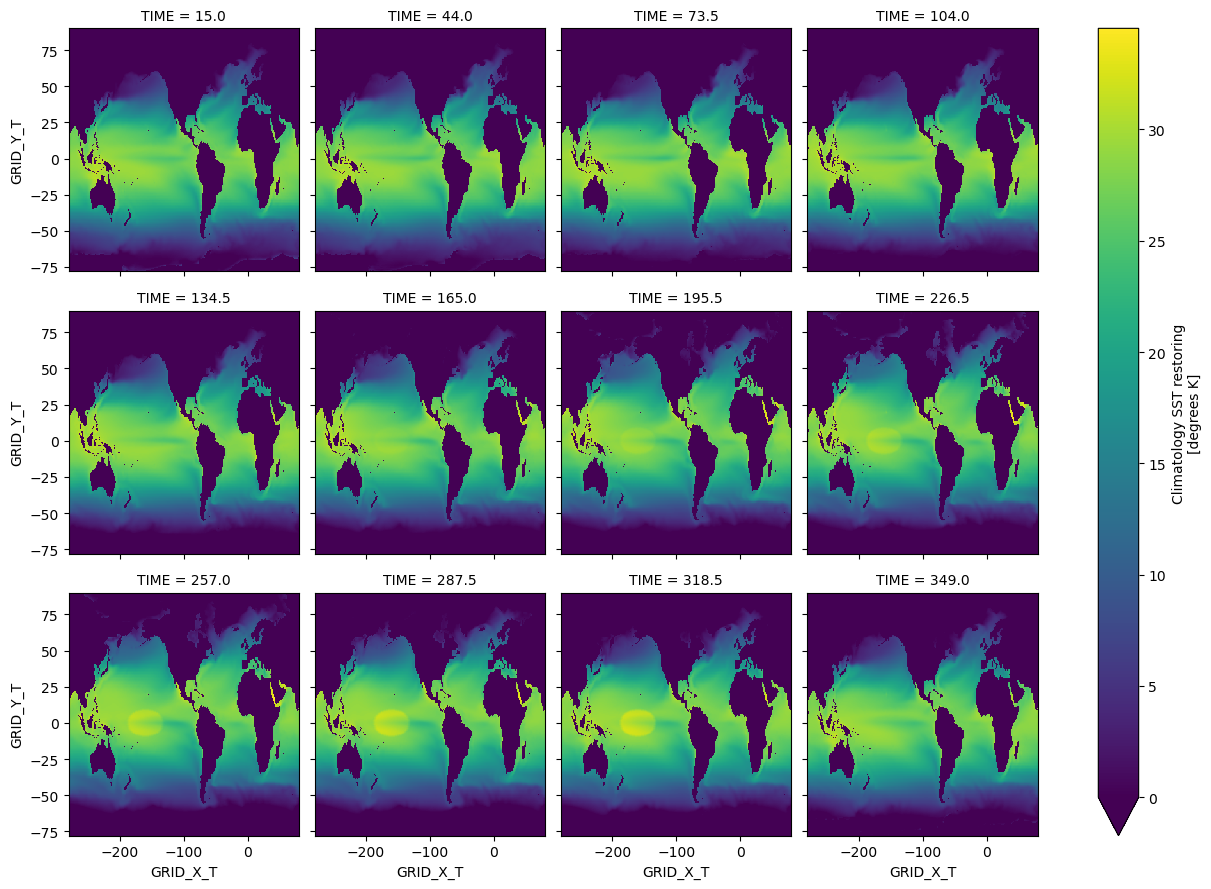

In [91]:
(idealised_CP_anom_yr1_jan.temp).plot(col = "TIME", col_wrap = 4, vmin = 0)

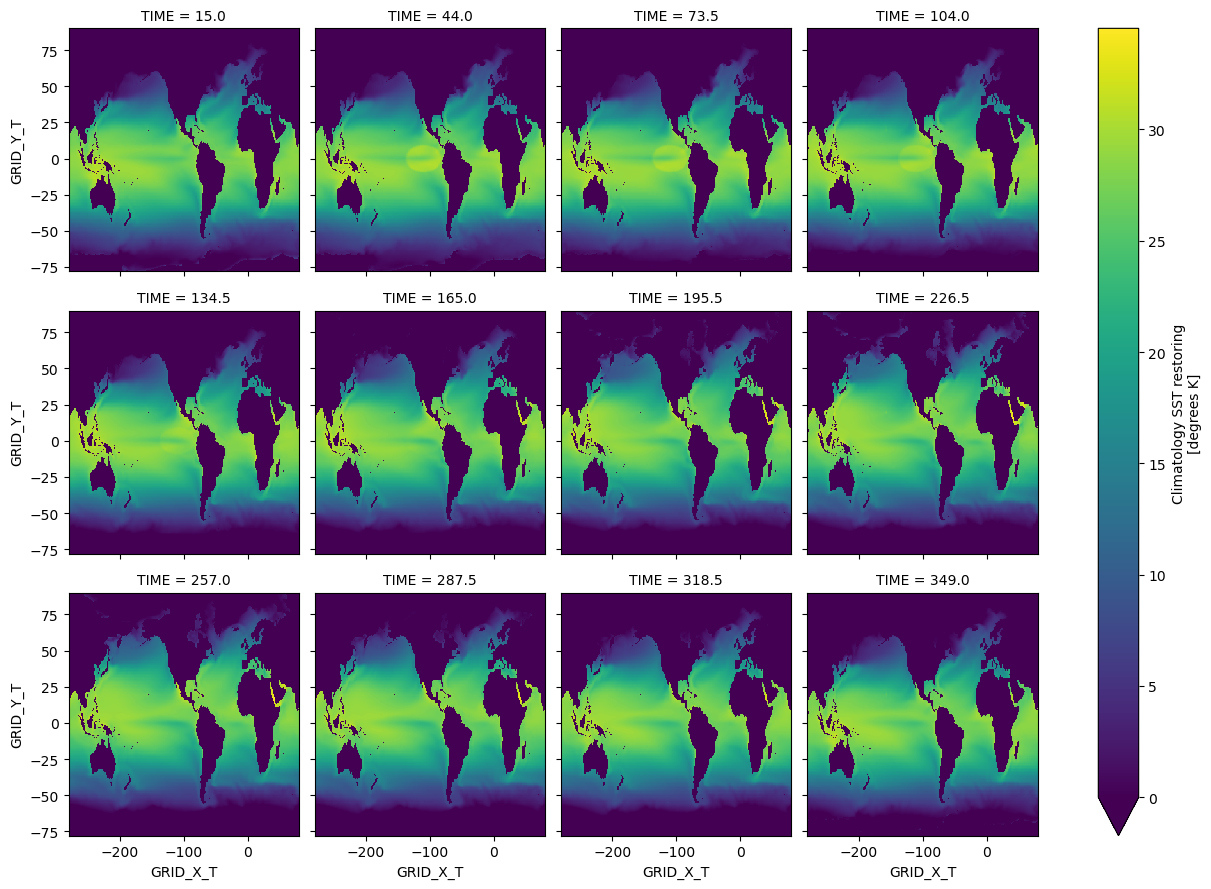

In [97]:
(idealised_EP_anom_yr2_jul.temp).plot(col = "TIME", col_wrap = 4, vmin = 0)

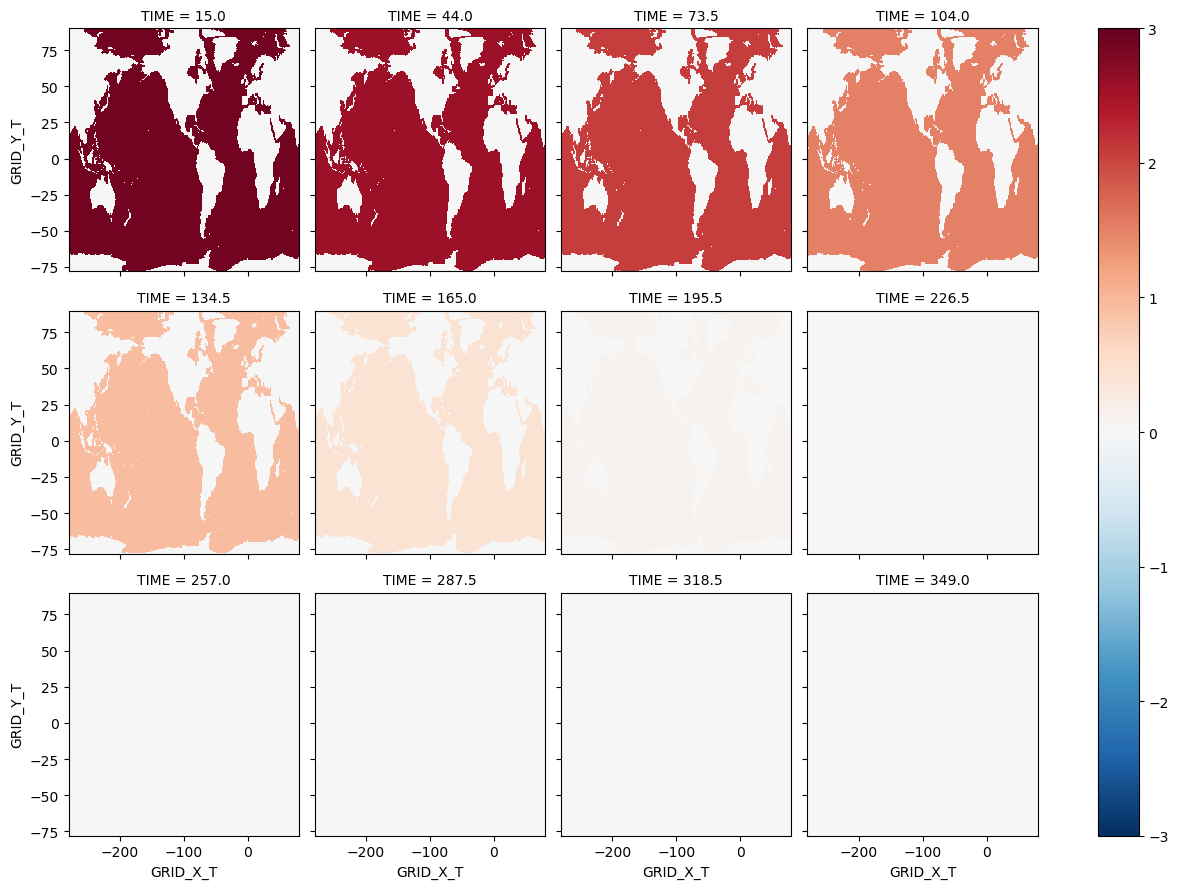

In [196]:
((MC + da_cosine_2)-MC).plot(col = "TIME", col_wrap = 4, vmin = -3)

In [118]:
MC

<xarray.DataArray 'temp' (TIME: 12, DEPTH1_1: 1, GRID_Y_T: 300, GRID_X_T: 360)>
[1296000 values with dtype=float32]
Coordinates:
  * TIME      (TIME) float64 15.0 44.0 73.5 104.0 ... 257.0 287.5 318.5 349.0
  * DEPTH1_1  (DEPTH1_1) float64 0.0
  * GRID_Y_T  (GRID_Y_T) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * GRID_X_T  (GRID_X_T) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
Attributes:
    _FillValue:   -1e+20
    long_name:    Climatology SST restoring
    units:        degrees K
    valid_range:  [-10. 500.]